In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import seaborn as sns
import datetime

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###NYC Historical Data: Complaints

[Data, New York City](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)

This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2019). For additional details, please see the attached data dictionary in the ‘About’ section.

## Exploracion Inicial de Datos

In [3]:
df_copy = pd.read_csv("/content/drive/MyDrive/Monografia_NYPD/NYPD_Complaint_Data_Historic.csv", 
                 dtype={"BORO_NM": "category", "CRM_ATPT_CPTD_CD": "category", 
                        "LAW_CAT_CD": "category", "LOC_OF_OCCUR_DESC": "category", 
                        "JURIS_DESC": "category", "JURISDICTION_CODE": "category", 
                        "SUSP_RACE": "category", "SUSP_SEX": "category",
                        "TRANSIT_DISTRICT": "category", "VIC_RACE": "category", 
                        "VIC_SEX": "category"}, low_memory=False, parse_dates = ["CMPLNT_FR_DT"])

In [4]:
df = df_copy.copy()

In [5]:
#%"CMPLNT_FR_DT": "datetime", "CMPLNT_TO_DT": "datetime", , "CMPLNT_FR_TM": "time", "CMPLNT_TO_TM": "time"

In [6]:
print(f"La base de datos cuenta con: {df.shape[0]} denuncias registradas y, un total de: {df.shape[1]} atributos (columnas) que describen el hecho")

La base de datos cuenta con: 7825499 denuncias registradas y, un total de: 35 atributos (columnas) que describen el hecho


In [7]:
#Se examina la presencia de valores nulos por cada columna:


#There are missing values for different columns:

#df.isna()
a = df.isnull().sum().to_frame().sort_values(by=[0], ascending=False)
a.rename(columns={0: "total_nulos"}, inplace = True)
a["%_nulos"] =round(df.apply(lambda x: 1-(x.count()/x.size))*100,2)
a
#df.style.format("{:,.0f}")

,total_nulos,%_nulos
PARKS_NM,7794644,99.61
STATION_NAME,7653024,97.80
TRANSIT_DISTRICT,7653024,97.80
HADEVELOPT,7477110,95.55
HOUSING_PSA,7226206,92.34
SUSP_AGE_GROUP,4883369,62.40
SUSP_SEX,3648142,46.62
SUSP_RACE,3514828,44.92
CMPLNT_TO_DT,1744294,22.29
CMPLNT_TO_TM,1739479,22.23


Adicional a lo anterior, hay presencia de valores nulos y atípicos que podrían estar en el mismo registro, es decir, en una misma denuncia hay varias características que no están bien diligenciadas o no cuentan con información. El siguiente código considera cada uno de los registros a nivel columna para hacer una evaluación en donde hay 20% de los nulos por fila

In [8]:
threshold = 0.3 # set the threshold to 30%
mask = df.isnull().mean(axis=1) > threshold # create a boolean mask
rows_with_many_nulls = df[mask] # select rows that meet the condition
print(f'Evaluando el dataset y revisando no sólo por columna si no por fila se encuenta que existen: {len(rows_with_many_nulls)} filas en donde hay presencia de por lo menos {threshold * df.shape[1]} atributos nulos' )

Evaluando el dataset y revisando no sólo por columna si no por fila se encuenta que existen: 432332 filas en donde hay presencia de por lo menos 10.5 atributos nulos


In [9]:
#Dada la extensión del fata set y, teniendo en cuenta, que se apunta a hacer una categorización precisa de los crímenes se procede a eliminarlos
df.drop(rows_with_many_nulls.index.to_numpy(), axis = 0, inplace = True)
df.shape

(7393167, 35)

In [10]:
#Se examina la presencia de valores nulos por cada columna:


#There are missing values for different columns:

#df.isna()
a = df.isnull().sum().to_frame().sort_values(by=[0], ascending=False)
a.rename(columns={0: "total_nulos"}, inplace = True)
a["%_nulos"] =round(df.apply(lambda x: 1-(x.count()/x.size))*100,2)
a
#df.style.format("{:,.0f}")

,total_nulos,%_nulos
PARKS_NM,7362589,99.59
STATION_NAME,7221564,97.68
TRANSIT_DISTRICT,7221564,97.68
HADEVELOPT,7045690,95.30
HOUSING_PSA,6795132,91.91
SUSP_AGE_GROUP,4456980,60.29
SUSP_SEX,3224841,43.62
SUSP_RACE,3093507,41.84
LOC_OF_OCCUR_DESC,1412561,19.11
CMPLNT_TO_DT,1324994,17.92


Variables que contienen más del 90% como valores nulos, son descartadass del análisis: PARKS_NM = nombre_area_suceso	(99.59%), STATION_NAME = nombre_estacion_transito (97.68%), TRANSIT_DISTRICT = distrito_transito	(97.68%), HADEVELOPT = nombre_urbanizacion (95.30%), HOUSING_PSA = codigo_nivel_desarrollo (91.91%)

In [11]:
#for i in df.columns:
#  if len(df[i].unique()) < 30:
#    print(f"La columna: {i}, contiene: {len(df[i].unique())} valores unicos")
#    print("_____________________")
#    print("_____________________")
#    print(df[i].value_counts())
#  else: 
#    pass

In [12]:
# print(df['PARKS_NM'].value_counts())
#print(df.drop_duplicates(subset = ["PARKS_NM"]))
# print(df['HOUSING_PSA'].value_counts())
#print(df.drop_duplicates(subset = ["HOUSING_PSA"]))

In [13]:
df.rename(columns={"CMPLNT_NUM": "num_denuncia"}, inplace=True)
df.rename(columns={"CMPLNT_FR_DT": "fecha_inicio_suceso"}, inplace=True)
df.rename(columns={"CMPLNT_FR_TM": "hora_inicio_suceso"}, inplace=True)
df.rename(columns={"CMPLNT_TO_DT": "fecha_final_suceso"}, inplace=True)
df.rename(columns={"CMPLNT_TO_TM": "hora_final_suceso"}, inplace=True)
df.rename(columns={"ADDR_PCT_CD": "direccion_suceso"}, inplace=True)
df.rename(columns={"RPT_DT": "fecha_denuncia"}, inplace=True)
df.rename(columns={"KY_CD": "codigo_clasificacion"}, inplace=True)
df.rename(columns={"OFNS_DESC": "descripcion_suceso"}, inplace=True)
df.rename(columns={"PD_CD": "codigo_clasificacion_granular"}, inplace=True)
df.rename(columns={"PD_DESC": "descripcion_codigo_clasificacion_granular"}, inplace=True)
df.rename(columns={"CRM_ATPT_CPTD_CD": "delito_completado_interrumpido"}, inplace=True)
df.rename(columns={"LAW_CAT_CD": "nivel_ofensa"}, inplace=True)
df.rename(columns={"BORO_NM": "distrito"}, inplace=True)
df.rename(columns={"LOC_OF_OCCUR_DESC": "ubicacion_especifica"}, inplace=True)
df.rename(columns={"PREM_TYP_DESC": "descripcion_ubicacion"}, inplace=True)
df.rename(columns={"JURIS_DESC": "descripcion_codigo_jurisdiccion"}, inplace=True)
df.rename(columns={"JURISDICTION_CODE": "jurisdiccion_encargada"}, inplace=True)
df.rename(columns={"PARKS_NM": "nombre_area_suceso"}, inplace=True)
df.rename(columns={"HADEVELOPT": "nombre_urbanizacion"}, inplace=True)
df.rename(columns={"HOUSING_PSA": "codigo_nivel_desarrollo"}, inplace=True)
df.rename(columns={"X_COORD_CD": "coordenada_x"}, inplace=True)
df.rename(columns={"Y_COORD_CD": "coordenada_y"}, inplace=True)
df.rename(columns={"SUSP_AGE_GROUP": "grupo_edad_sospechoso"}, inplace=True)
df.rename(columns={"SUSP_RACE": "raza_sospechoso"}, inplace=True)
df.rename(columns={"SUSP_SEX": "sexo_sospechoso"}, inplace=True)
df.rename(columns={"TRANSIT_DISTRICT": "distrito_transito"}, inplace=True)
df.rename(columns={"Latitude": "latitud"}, inplace=True)
df.rename(columns={"Longitude": "longitud"}, inplace=True)
df.rename(columns={"Lat_Lon": "geoespacial"}, inplace=True)
df.rename(columns={"PATROL_BORO": "nombre_patrulla_suceso"}, inplace=True)
df.rename(columns={"STATION_NAME": "nombre_estacion_transito"}, inplace=True)
df.rename(columns={"VIC_AGE_GROUP": "grupo_edad_victima"}, inplace=True)
df.rename(columns={"VIC_RACE": "raza_victima"}, inplace=True)
df.rename(columns={"VIC_SEX": "sexo_victima"}, inplace=True)

Se elimina codigo de clasificacion y se centra el analisis en el tipo de crimen

In [14]:
df.drop(columns=["nombre_area_suceso", "nombre_estacion_transito", "distrito_transito", 
                 "nombre_urbanizacion", "codigo_nivel_desarrollo", 
                 "codigo_clasificacion", "codigo_clasificacion_granular", 
                 "ubicacion_especifica", "descripcion_codigo_clasificacion_granular", "descripcion_codigo_jurisdiccion", "nombre_patrulla_suceso",
                 "coordenada_x", "coordenada_y"], inplace = True)
print(len(df.columns))
print(df.columns)

22
Index(['num_denuncia', 'fecha_inicio_suceso', 'hora_inicio_suceso',
       'fecha_final_suceso', 'hora_final_suceso', 'direccion_suceso',
       'fecha_denuncia', 'descripcion_suceso',
       'delito_completado_interrumpido', 'nivel_ofensa', 'distrito',
       'descripcion_ubicacion', 'jurisdiccion_encargada',
       'grupo_edad_sospechoso', 'raza_sospechoso', 'sexo_sospechoso',
       'latitud', 'longitud', 'geoespacial', 'grupo_edad_victima',
       'raza_victima', 'sexo_victima'],
      dtype='object')


descripcion_codigo_jurisdiccion, se elimina ya que en jurisdiccion encargada se agrupa cada ente responsable, nombre_patrulla_suceso se elimina ya que cada patrulla es inherente al Distrito

In [15]:
#NO eliminar "grupo_edad_sospechoso", "grupo_edad_victima" y darle tratamiento a los nulos y atipicos

In [16]:
df.jurisdiccion_encargada = np.where(df.jurisdiccion_encargada == '0', 'Policia', np.where(df.jurisdiccion_encargada == '1', 'Transito', np.where(df.jurisdiccion_encargada == '2', 'Vivienda', np.where(df.jurisdiccion_encargada == '3', 'Externas', 'Otras'))))

In [17]:
df.jurisdiccion_encargada.value_counts()

Policia     6542514
Vivienda     592248
Transito     171607
Otras         54165
Externas      32633
Name: jurisdiccion_encargada, dtype: int64

In [18]:
df_dis_precint = df[['distrito', 'direccion_suceso']].groupby(['distrito', 'direccion_suceso']).count().reset_index()
df_dis_precint

,distrito,direccion_suceso
0,BRONX,1.0
1,BRONX,5.0
2,BRONX,6.0
3,BRONX,7.0
4,BRONX,9.0
...,...,...
380,STATEN ISLAND,115.0
381,STATEN ISLAND,120.0
382,STATEN ISLAND,121.0
383,STATEN ISLAND,122.0


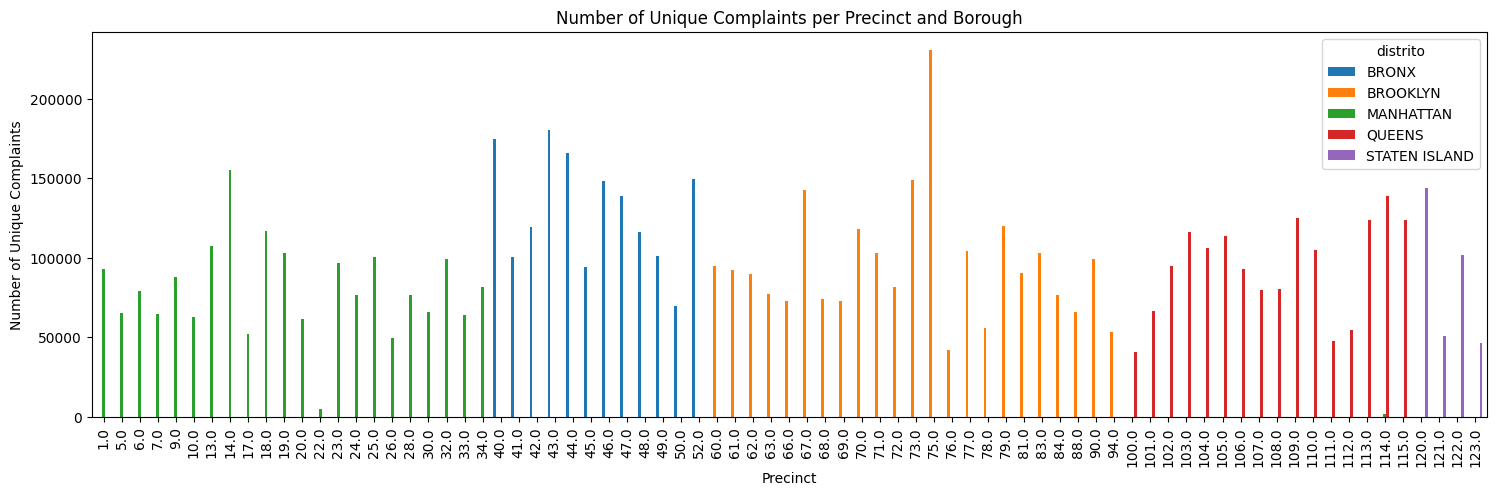

In [19]:
df_dis_precint = df.groupby(['distrito', 'direccion_suceso'])['num_denuncia'].count().reset_index()

# Pivot the data to prepare for plotting
pivot_df = df_dis_precint.pivot(index='direccion_suceso', columns='distrito', values='num_denuncia')

# Create the bar chart
pivot_df.plot(kind='bar', figsize=(18,5), width=0.8)

# Add title and axis labels
plt.title("Number of Unique Complaints per Precinct and Borough")
plt.xlabel("Precinct")
plt.ylabel("Number of Unique Complaints")

# Show the plot
plt.show()

In [20]:
df.columns

Index(['num_denuncia', 'fecha_inicio_suceso', 'hora_inicio_suceso',
       'fecha_final_suceso', 'hora_final_suceso', 'direccion_suceso',
       'fecha_denuncia', 'descripcion_suceso',
       'delito_completado_interrumpido', 'nivel_ofensa', 'distrito',
       'descripcion_ubicacion', 'jurisdiccion_encargada',
       'grupo_edad_sospechoso', 'raza_sospechoso', 'sexo_sospechoso',
       'latitud', 'longitud', 'geoespacial', 'grupo_edad_victima',
       'raza_victima', 'sexo_victima'],
      dtype='object')

Dado que las variables de edad contienen ruido, para evitar perder informaciíon en otras columnas se reemplaza por edad 'desconocida' pues tiene sentido que muchas de las denuncias (crimenes) no haya una descripción exacta de dichas personas.

In [21]:
mask1 = ~df.grupo_edad_sospechoso.isin(['25-44', '18-44', '<18', '45-64'])
df.grupo_edad_sospechoso = np.where(mask1, "UNKNOWN", df.grupo_edad_sospechoso)

In [22]:
mask2 = ~df.grupo_edad_victima.isin(['25-44', '18-44', '<18', '45-64'])
df.grupo_edad_victima = np.where(mask2, "UNKNOWN", df.grupo_edad_victima)

In [23]:
df.raza_victima.value_counts()
df.raza_victima = np.where(df.raza_victima == 'OTHER', 'UNKNOWN', np.where(df.raza_victima == 'BLACK HISPANIC', 'BLACK', np.where(df.raza_victima == 'WHITE HISPANIC', 'WHITE', df.raza_victima)))

In [24]:
df.raza_victima.value_counts()

WHITE                             2561747
UNKNOWN                           2222776
BLACK                             2117516
ASIAN / PACIFIC ISLANDER           456709
AMERICAN INDIAN/ALASKAN NATIVE      34332
Name: raza_victima, dtype: int64

In [25]:
df.sexo_victima 
mask3 = ~df.sexo_victima.isin(['F', 'M'])
df.sexo_victima = np.where(mask3, 'UNKNOWN',  df.sexo_victima)

In [26]:
df.sexo_sospechoso.value_counts()

M    2597067
F     812026
U     759233
Name: sexo_sospechoso, dtype: int64

In [27]:
#Esta columna con la idea de mirar en promedio cuántos días pasan entre la fecha en que comienza el hecho y la fecha en que termina.
#Para fechas podría no ser relevante para hechos como robos que generalmente duran minutos o hasta segundos.
#Para tiempo, podría en algún caso ser últil para la capacidad de reacción de alguna patrulla en lo que identifica un hecho sea porque
#hay un sospechoso, en cierta zona, con algunas caracteristicas dada (como edad, raza y sexo) y una posible victima con otras caracterísiticas.

#Se remueve una fila que contiene un dato: 1018-09-28
#df.drop(df['fecha_inicio_suceso'] == '1018-09-28').index
df['fecha_inicio_suceso'] = pd.to_datetime(df['fecha_inicio_suceso'], errors='coerce')
df['fecha_final_suceso'] = pd.to_datetime(df['fecha_final_suceso'], errors = 'coerce')

df["fecha_denuncia"] = pd.to_datetime(df["fecha_denuncia"], errors = 'coerce')

#Considerando que hay NaT en la columna fecha_final_suceso, se van a excluir esas filas y luego con el promedio de días se va a sumar a la fecha_inicio_suceso

# calculate the time difference in days for non-null values
not_null_mask = pd.notnull(df['fecha_final_suceso']) & pd.notnull(df['fecha_inicio_suceso'])
df['diferencia_dias_suceso'] = (df.loc[not_null_mask, 'fecha_final_suceso'] - df.loc[not_null_mask, 'fecha_inicio_suceso']).dt.days

# calculate the mean time difference in days for non-null values
mean_diferencia_dias_suceso = df['diferencia_dias_suceso'].mean()

# print the result
print(f"En promedio, para los hechos en que existe una fecha de finalización de suceso, el promedio de días que toman los hechos es de:  {mean_diferencia_dias_suceso: .2f} días")
print(f"Sin embargo, para no entrar en detalle, dado que la misma base lo describe así, la fecha inicio puede ser tomada como la fecha exacta del suceso")

En promedio, para los hechos en que existe una fecha de finalización de suceso, el promedio de días que toman los hechos es de:   8.91 días
Sin embargo, para no entrar en detalle, dado que la misma base lo describe así, la fecha inicio puede ser tomada como la fecha exacta del suceso


In [28]:
df.drop(columns=["fecha_final_suceso",	"hora_final_suceso"], inplace=True)
df.rename(columns={"fecha_inicio_suceso": "fecha_suceso"}, inplace=True)
df.rename(columns={"hora_inicio_suceso": "hora_suceso"}, inplace=True)

In [29]:
df.dropna().shape

(3254767, 21)

In [30]:
#There are missing values for different columns:

#df.isna()
a = df.isnull().sum().to_frame().sort_values(by=[0], ascending=False)
a.rename(columns={0: "total_nulos"}, inplace = True)
a["%_nulos"] =round(df.apply(lambda x: 1-(x.count()/x.size))*100,2)
a
#df.style.format("{:,.0f}")

,total_nulos,%_nulos
sexo_sospechoso,3224841,43.62
raza_sospechoso,3093507,41.84
diferencia_dias_suceso,1325597,17.93
descripcion_ubicacion,27805,0.38
descripcion_suceso,13428,0.18
distrito,4163,0.06
longitud,1400,0.02
geoespacial,1400,0.02
latitud,1400,0.02
fecha_suceso,724,0.01


In [31]:
threshold = 0.3 # set the threshold to 30%
mask = df.isnull().mean(axis=1) > threshold # create a boolean mask
rows_with_many_nulls = df[mask] # select rows that meet the condition

In [32]:
df['sexo_sospechoso'].value_counts()

M    2597067
F     812026
U     759233
Name: sexo_sospechoso, dtype: int64

In [33]:
df['raza_sospechoso'].value_counts()

BLACK                             1598025
UNKNOWN                           1142361
WHITE HISPANIC                     724182
WHITE                              462390
BLACK HISPANIC                     220804
ASIAN / PACIFIC ISLANDER           139247
AMERICAN INDIAN/ALASKAN NATIVE      12641
OTHER                                  10
Name: raza_sospechoso, dtype: int64

In [34]:
#sexo_sospechoso y raza_sospechoso, son imputadas y, una vez hecho esto, se elige la muestra para trabajar el ejercicio:

df['sexo_sospechoso'] = df['sexo_sospechoso'].fillna('U')
df['raza_sospechoso'] = df['raza_sospechoso'].fillna('UNKNOWN')
df.drop(columns=["diferencia_dias_suceso"], inplace=True)

In [35]:
print(len(df))
df.shape

7393167


(7393167, 20)

In [36]:
#There are missing values for different columns:

#df.isna()
a = df.isnull().sum().to_frame().sort_values(by=[0], ascending=False)
a.rename(columns={0: "total_nulos"}, inplace = True)
a["%_nulos"] =round(df.apply(lambda x: 1-(x.count()/x.size))*100,2)
a
#df.style.format("{:,.0f}")

,total_nulos,%_nulos
descripcion_ubicacion,27805,0.38
descripcion_suceso,13428,0.18
distrito,4163,0.06
geoespacial,1400,0.02
longitud,1400,0.02
latitud,1400,0.02
fecha_suceso,724,0.01
raza_victima,87,0.00
hora_suceso,39,0.00
delito_completado_interrumpido,28,0.00


In [37]:
threshold = 0.3 # set the threshold to 30%
mask = df.isnull().mean(axis=1) > threshold # create a boolean mask
rows_with_many_nulls = df[mask] # select rows that meet the condition

In [38]:
print(len(rows_with_many_nulls))

0


In [39]:
df_not_na = df.dropna()
print(df_not_na.shape)
print(len(df_not_na))

(7345635, 20)
7345635


A continuación se generan agrupaciones para las categorías principales: lugar y tipo de crimen

In [40]:
dic_crimenes = {'CRIMINAL MISCHIEF & RELATED OF' : 'Orden publico', 
'PETIT LARCENY': 'Robos y hurtos',
'OFF. AGNST PUB ORD SENSBLTY &' : 'Orden publico', 
'FORGERY' : 'Fraude', 
'DANGEROUS WEAPONS' : 'Armas',
'ASSAULT 3 & RELATED OFFENSES' : 'Delito mayor', 
'FELONY ASSAULT': 'Delito mayor', 
'GRAND LARCENY' : 'Robos y hurtos',
'OFFENSES AGAINST PUBLIC ADMINI' : 'Orden publico', 
'ROBBERY' : 'Robos y hurtos', 
'HARRASSMENT 2' : 'Acoso',
'DANGEROUS DRUGS' : 'Trafico de drogas', 
'SEX CRIMES' : 'Crimenes sexuales', 
'VEHICLE AND TRAFFIC LAWS' : 'Leyes de transito',
'OTHER OFFENSES RELATED TO THEF': 'Robos y hurtos', 
'CRIMINAL TRESPASS' : 'Robos y hurtos',
'OFFENSES AGAINST THE PERSON' : 'Acoso', 
'BURGLARY' : 'Robos y hurtos',
'POSSESSION OF STOLEN PROPERTY' : 'Delito mayor', 
'MISCELLANEOUS PENAL LAW' : 'Crimen fallido',
'ARSON' : 'Orden publico', 
'GRAND LARCENY OF MOTOR VEHICLE' : 'Robos y hurtos', 
'RAPE' : 'Crimenes sexuales',
'OFFENSES INVOLVING FRAUD' : 'Fraude', 
'INTOXICATED & IMPAIRED DRIVING' : 'Leyes de transito',
'UNAUTHORIZED USE OF A VEHICLE' : 'Leyes de transito', 
'NYS LAWS-UNCLASSIFIED FELONY' : 'Delito menor',
'OTHER STATE LAWS (NON PENAL LA' : 'Delito menor', 
'FRAUDS' : 'Fraude', 
'THEFT-FRAUD' : 'Robos y hurtos',
'ADMINISTRATIVE CODE' : 'Delitos administrativos', 
'nan': 'Otros crimenes', 
'OFFENSES AGAINST PUBLIC SAFETY' : 'Orden publico',
'DISORDERLY CONDUCT' : 'Orden publico', 
'ANTICIPATORY OFFENSES' : 'Concierto para delinquir', 
'JOSTLING' : 'Riñas',
'KIDNAPPING & RELATED OFFENSES' : 'Secuestro y relacionados', 
'MURDER & NON-NEGL. MANSLAUGHTER' : 'Homicidio',
'ALCOHOLIC BEVERAGE CONTROL LAW' : 'Orden publico', 
'THEFT OF SERVICES' : 'Robos y hurtos',
"BURGLAR'S TOOLS" : 'Robos y hurtos', 
'FRAUDULENT ACCOSTING': 'Fraude', 
'GAMBLING' : 'Fraude',
'PETIT LARCENY OF MOTOR VEHICLE' : 'Robos y hurtos',
'AGRICULTURE & MRKTS LAW-UNCLASSIFIED' : 'Orden publico',
'PROSTITUTION & RELATED OFFENSES' : 'Crimenes sexuales', 
'CHILD ABANDONMENT/NON SUPPORT' : 'Crimenes sexuales',
'OFFENSES RELATED TO CHILDREN' : 'Crimenes sexuales', 
'ENDAN WELFARE INCOMP' : 'Acoso', 
'ABORTION' : 'Crimenes sexuales',
'NYS LAWS-UNCLASSIFIED VIOLATION': 'Crimenes sexuales', 
'OTHER STATE LAWS': 'Otros crimenes',
'INTOXICATED/IMPAIRED DRIVING' : 'Leyes de transito', 
'KIDNAPPING' : 'Secuestro y relacionados', 
'ESCAPE 3' : 'Fuga',
'HOMICIDE-NEGLIGENT,UNCLASSIFIE' : 'Homicidio', 
'LOITERING/GAMBLING (CARDS, DIC' : 'Fraude',
'NEW YORK CITY HEALTH CODE' : 'Salud Publica', 
'UNLAWFUL POSS. WEAP. ON SCHOOL' : 'Armas',
'UNDER THE INFLUENCE OF DRUGS' : 'Orden publico', 
'HOMICIDE-NEGLIGENT-VEHICLE' : 'Leyes de transito',
'OTHER TRAFFIC INFRACTION' : 'Leyes de transito', 
'ADMINISTRATIVE CODES' : 'Delitos administrativos',
'OTHER STATE LAWS (NON PENAL LAW)' : 'Otros crimenes',
'DISRUPTION OF A RELIGIOUS SERV' : 'Orden publico', 
'FELONY SEX CRIMES' : 'Crimenes sexuales',
'OFFENSES AGAINST MARRIAGE UNCL' : 'Crimenes sexuales', 
'FORTUNE TELLING' : 'Fraude',
'KIDNAPPING AND RELATED OFFENSES' : 'Secuestro y relacionados', 
'LOITERING' : 'Fraude',
'LOITERING FOR DRUG PURPOSES' : 'Trafico de drogas', 
'LOITERING/DEVIATE SEX' : 'Crimenes sexuales'}

dic_location = {'PARKING LOT/GARAGE (PUBLIC)' : 'Parqueadero', 
'DEPARTMENT STORE' : 'Zona de comercio',
 'STREET' : 'Calle',
 'RESIDENCE - APT. HOUSE' : 'Zona residencial', 
'CHAIN STORE' : 'Zona de comercio',
 'TRANSIT - NYC SUBWAY' : 'Transporte publico',
 'FAST FOOD' : 'Restaurante',
 'RESIDENCE-HOUSE' : 'Zona residencial',
 'BAR/NIGHT CLUB' : 'club nocturno', 
'MAILBOX OUTSIDE' : 'Zona residencial', 
'STORAGE FACILITY' : 'Bodega',
 'TELECOMM. STORE' : 'Zona de comercio', 
'GROCERY/BODEGA' : 'Bodega', 
'DRUG STORE' : 'Zona de comercio',
 'RESIDENCE - PUBLIC HOUSING' : 'Zona residencial', 
'SMALL MERCHANT' : 'Zona de comercio', 
'COMMERCIAL BUILDING': 'Zona de comercio',
 'OTHER': 'Otros', 
'FOOD SUPERMARKET': 'Restaurante', 
'RESTAURANT/DINER': 'Restaurante', 
'ABANDONED BUILDING' : 'Edificio abandonado',
 'LIQUOR STORE' : 'Licorera', 
'DOCTOR/DENTIST OFFICE' : 'Servicios de salud', 
'nan' : 'No registrado', 
'AIRPORT TERMINAL' : 'Transporte publico',
 'DRY CLEANER/LAUNDRY' : 'Zona de comercio', 
'CLOTHING/BOUTIQUE' : 'Zona de comercio', 
'MOSQUE' : 'Templo religioso', 
'HIGHWAY/PARKWAY' : 'Calle',
 'PARKING LOT/GARAGE (PRIVATE)' : 'Parqueadero', 
'PARK/PLAYGROUND' : 'Parque', 
'BANK' : 'Servicios financieros',
 'BUS (NYC TRANSIT)' : 'Transporte publico', 
'JEWELRY' : 'Zona de comercio', 
'GYM/FITNESS FACILITY' : 'Zona de comercio', 
'HOSPITAL' : 'Servicios de salud',
 'PRIVATE/PAROCHIAL SCHOOL' : 'Institucion educativa', 
'STORE UNCLASSIFIED' : 'Zona de comercio', 
'HOTEL/MOTEL' : 'Hotel',
 'PUBLIC SCHOOL' : 'Institucion educativa', 
'GAS STATION' : 'Zona de comercio', 
'TUNNEL' : 'Calle', 
'CHURCH': 'Templo religioso', 
'PUBLIC BUILDING': 'Centros publicos',
 'CONSTRUCTION SITE' : 'Construccion', 
'BEAUTY & NAIL SALON' : 'Zona de comercio', 
'BUS (OTHER)' : 'Transporte publico',
 'OPEN AREAS (OPEN LOTS)' : 'Parque', 
'MARINA/PIER' : 'Muelle', 
'ATM' : 'Servicios financieros', 
'SHOE' : 'Zona de comercio', 
'VARIETY STORE' : 'Zona de comercio',
 'CHECK CASHING BUSINESS' : 'Servicios financieros', 
'TAXI (YELLOW LICENSED)' : 'Transporte publico', 
'SOCIAL CLUB/POLICY' : 'club nocturno',
 'TAXI (LIVERY LICENSED)' : 'Transporte publico', 
'CANDY STORE' : 'Zona de comercio', 
'FERRY/FERRY TERMINAL' : 'Transporte publico',
 'TRANSIT FACILITY (OTHER)' : 'Transporte publico', 
'BUS TERMINAL' : 'Transporte publico', 
'TAXI/LIVERY (UNLICENSED)' : 'Transporte publico',
 'BUS STOP' : 'Transporte publico', 
'FACTORY/WAREHOUSE' : 'Bodega', 
'PHOTO/COPY' : 'Zona de comercio', 
'BRIDGE' : 'Calle', 
'MAILBOX INSIDE' : 'Zona residencial',
'BOOK/CARD' : 'Zona de comercio', 
'OTHER HOUSE OF WORSHIP' : 'Templo religioso', 
'SYNAGOGUE' : 'Templo religioso', 
'VIDEO STORE' : 'Zona de comercio',
'LOAN COMPANY' : 'Servicios financieros', 
'CEMETERY' : 'Centros publicos',
'TRAMWAY' : 'Transporte publico',
'HOMELESS SHELTER' : 'Calle', 
'DAYCARE FACILITY' : 'Institucion educativa'}

In [41]:
a = df["descripcion_suceso"].drop_duplicates()
print(len(a.unique()))

71


In [42]:
df["descripcion_suceso"].value_counts()

PETIT LARCENY                      1240593
HARRASSMENT 2                      1014645
ASSAULT 3 & RELATED OFFENSES        809920
CRIMINAL MISCHIEF & RELATED OF      744122
GRAND LARCENY                       658035
                                    ...   
OTHER TRAFFIC INFRACTION                 8
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
KIDNAPPING AND RELATED OFFENSES          3
UNDER THE INFLUENCE OF DRUGS             3
Name: descripcion_suceso, Length: 70, dtype: int64

In [43]:
b = df["descripcion_ubicacion"].drop_duplicates()
print(len(b.unique()))

75


In [44]:
df["tipo_crimen"]=df["descripcion_suceso"].replace(dic_crimenes)
df["lugar"]=df["descripcion_ubicacion"].replace(dic_location)

In [45]:
df["tipo_crimen"].value_counts().to_frame()

,tipo_crimen
Robos y hurtos,2754037
Orden publico,1292748
Delito mayor,1145454
Acoso,1032510
Trafico de drogas,341671
Crimen fallido,192253
Leyes de transito,189183
Armas,140377
Fraude,139351
Crimenes sexuales,119689


In [46]:
df["lugar"].value_counts().to_frame()

,lugar
Zona residencial,2990716
Calle,2293426
Zona de comercio,811144
Transporte publico,239122
Otros,194770
Restaurante,162084
Bodega,110504
Institucion educativa,90905
Parque,88301
club nocturno,83044


In [47]:
df['hora_suceso'] = pd.to_datetime(df['hora_suceso'],format= '%H:%M:%S').dt.time
df.drop(columns=["descripcion_suceso", "descripcion_ubicacion"], inplace = True)

In [48]:
#df.to_csv('df_iter1.csv', index= False)

In [49]:
#from google.colab import files
#files.download('/content/df_iter1.csv')

In [50]:
#df =  pd.read_csv("/content/df_iter1.csv", low_memory=False)

In [51]:
df1 = df.sample(frac=0.10, replace=True, random_state=1)

In [52]:
obj_cat_df = df1[['delito_completado_interrumpido', 'nivel_ofensa', 'distrito', 'raza_sospechoso', 'sexo_sospechoso',
       'raza_victima', 'sexo_victima',
       'tipo_crimen', 'lugar']]

In [53]:
ohc = OneHotEncoder(sparse = False)

In [54]:
df_encoder = ohc.fit_transform(obj_cat_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
#df = pd.concat([df["num_denuncia"], df["fecha_suceso"], df["hora_suceso"], df["geoespacial"], obj_cat_df], sort = False)

# Convertir la matriz sparse resultante a un dataframe
encoded_df = pd.DataFrame(df_encoder, 
                          columns = ohc.get_feature_names_out())
# asegurarnos de que los dataframes tengan la misma cantidad de filas y estén en el mismo orden
df_encoded = encoded_df.reset_index(drop=True)
df_original = df1.reset_index(drop=True)

df_concatenado = pd.concat([df_original[["latitud", "longitud"]], df_encoded], axis=1)
df_concatenado = df_concatenado.dropna()
#df_concatenado =  df_encoded

##### Standarization and PCA before running KMeans (1st iteration)

In [56]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_concatenado)

In [57]:
pca = PCA()
pca.fit(segmentation_std)

PCA()

In [58]:
pca.explained_variance_ratio_

array([6.02337417e-02, 3.94057865e-02, 3.26413218e-02, 3.13634843e-02,
       2.76823222e-02, 2.61285545e-02, 2.54390132e-02, 2.38128904e-02,
       2.29664426e-02, 2.10134761e-02, 1.77505709e-02, 1.74318718e-02,
       1.60142118e-02, 1.59417489e-02, 1.58063605e-02, 1.54379187e-02,
       1.47839405e-02, 1.46137969e-02, 1.44248051e-02, 1.40111531e-02,
       1.39349667e-02, 1.38748354e-02, 1.37969150e-02, 1.37534805e-02,
       1.36585886e-02, 1.35245254e-02, 1.34880894e-02, 1.34613590e-02,
       1.34097685e-02, 1.33996147e-02, 1.33770555e-02, 1.33670728e-02,
       1.33532849e-02, 1.33467911e-02, 1.33420860e-02, 1.33377843e-02,
       1.33337789e-02, 1.33328952e-02, 1.33317586e-02, 1.33284335e-02,
       1.33238055e-02, 1.33127925e-02, 1.33058113e-02, 1.32975734e-02,
       1.32647763e-02, 1.32373108e-02, 1.32287320e-02, 1.31595591e-02,
       1.30666943e-02, 1.29394794e-02, 1.27977584e-02, 1.27561556e-02,
       1.26060296e-02, 1.23160348e-02, 1.20012937e-02, 1.14742152e-02,
      

Text(0, 0.5, 'Cumulative explained variance')

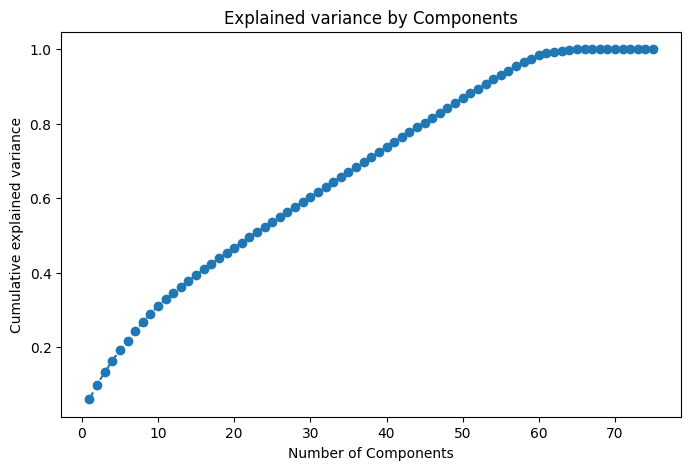

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 76), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--")
plt.title("Explained variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative explained variance")

##Iteración 1

##KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


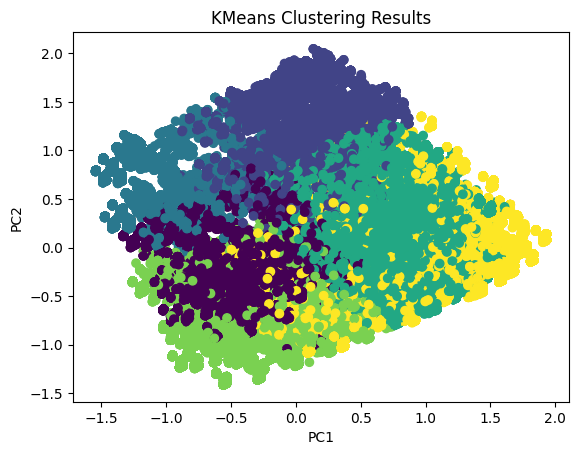

In [60]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load data from a CSV file into a pandas dataframe
data = df_concatenado

# Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=6)

# Fit the model to the data
kmeans.fit(data)

# Get the cluster labels
labels = kmeans.labels_

# Use PCA to reduce the dimensions of your data to a 2D space
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

# Create a scatter plot of the data with the points colored according to their assigned cluster label
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering Results')
plt.show()


In [61]:
clusters= [10, 7, 5, 3]
data = df_concatenado

#data2 = data.sample(frac=0.10, replace=True, random_state=1)

labels_KModel= {}

for cluster in clusters: 
  # fit the model

  kmeans = KMeans(n_clusters=cluster)
  kmeans.fit(data)
  labels = kmeans.labels_
  labels_KModel[f'NClus{cluster}'] = labels
  print(cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


In [62]:
#data2 = data.sample(frac=0.5, replace=False, random_state=1)
silhouette_avgClus= {}

Nsample= 0
for key in list(labels_KModel.keys()):
  data2 = data.sample(frac= Nsample+0.05, replace=True, random_state=1)
  #silhouette_score
  n = int(len(labels_KModel[key]) * (Nsample+0.05))
  if len(data2) != n:
    n += 1
  else:
    n = n
  lab2 = np.random.choice(labels_KModel[key], n , replace=True)
  silhouette_avg = silhouette_score(data2, lab2)
  silhouette_avgClus[key]= silhouette_avg
  print(f"Silhouette score {key}: {silhouette_avg}")
  Nsample= Nsample+0.05
  print(f'Sample Size {Nsample}')

Silhouette score NClus10: -0.0034825036281266324
Sample Size 0.05
Silhouette score NClus7: -0.0019889106318434473
Sample Size 0.1
Silhouette score NClus5: -0.000819752322015265
Sample Size 0.15000000000000002
Silhouette score NClus3: -0.00045008295894481524
Sample Size 0.2


###Extracción de información de características ya existentes

In [63]:
df_base = df

In [64]:
#There are missing values for different columns:

#df.isna()
a = df_base.isnull().sum().to_frame().sort_values(by=[0], ascending=False)
a.rename(columns={0: "total_nulos"}, inplace = True)
a["%_nulos"] =round(df_base.apply(lambda x: 1-(x.count()/x.size))*100,2)
a
#df.style.format("{:,.0f}")

,total_nulos,%_nulos
lugar,27805,0.38
tipo_crimen,13428,0.18
distrito,4163,0.06
latitud,1400,0.02
geoespacial,1400,0.02
longitud,1400,0.02
fecha_suceso,724,0.01
raza_victima,87,0.00
hora_suceso,39,0.00
delito_completado_interrumpido,28,0.00


In [65]:
df_base = df_base.dropna(subset = ["distrito", "geoespacial", "fecha_suceso", "raza_victima", "sexo_victima", "hora_suceso", "delito_completado_interrumpido"])

In [66]:
df_base['fecha_suceso']

0         2018-03-29
1         2018-02-06
2         2018-11-21
3         2018-06-09
4         2018-11-10
             ...    
7825494   2008-05-01
7825495   2018-05-18
7825496   2018-11-19
7825497   2018-02-03
7825498   2018-01-05
Name: fecha_suceso, Length: 7386726, dtype: datetime64[ns]

In [67]:
#df_base['hora_suceso'] = pd.to_datetime(df_base['hora_suceso'],format= '%H:%M:%S').dt.time

#Se remueve una fila que contiene un dato: 1018-09-28
#df_base.drop(df_base['fecha_suceso'] == '1018-09-28').index

df_base['fecha_suceso'] = pd.to_datetime(df_base['fecha_suceso'], format='%Y-%m-%d').dt.strftime('%m-%d-%Y')
df_base['fecha_denuncia'] = pd.to_datetime(df_base['fecha_denuncia'], format='%Y-%m-%d').dt.strftime('%m-%d-%Y')

print(pd.to_datetime(df_base['fecha_suceso'], errors='coerce').isna().sum())
print(pd.to_datetime(df_base['fecha_denuncia'], errors='coerce').isna().sum())

<ipython-input-67-40fd97765610>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base['fecha_suceso'] = pd.to_datetime(df_base['fecha_suceso'], format='%Y-%m-%d').dt.strftime('%m-%d-%Y')
<ipython-input-67-40fd97765610>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base['fecha_denuncia'] = pd.to_datetime(df_base['fecha_denuncia'], format='%Y-%m-%d').dt.strftime('%m-%d-%Y')


0
0


In [68]:
df_base.dropna(subset=['fecha_suceso'], inplace=True)
df_base['fecha_suceso'] = df_base['fecha_suceso'].astype(str).str.replace('-:', '')
df_base = df_base[~df_base['fecha_suceso'].isna()]

<ipython-input-68-1f419f26e281>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base.dropna(subset=['fecha_suceso'], inplace=True)
<ipython-input-68-1f419f26e281>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base['fecha_suceso'] = df_base['fecha_suceso'].astype(str).str.replace('-:', '')


In [69]:
df_base['fecha_suceso'] = pd.to_datetime(df_base['fecha_suceso'])
df_base['fecha_denuncia'] = pd.to_datetime(df_base['fecha_denuncia'])
df_base['diff_dias_hecho_denuncia'] = (df_base['fecha_denuncia'] - df_base['fecha_suceso']).dt.days.astype(int)

In [70]:
#Madrugada: Desde las 00:00 a las 06:00.
#Mañana: Desde las 06:00 a las 12:00 del mediodía.
#Tarde: Desde las 12:00 del mediodía hasta las 18:00 aproximadamente.
#Noche: Desde las 18:00 hasta las 00:00 aproximadamente.

df_base['hora_suceso'] = pd.to_datetime(df_base['hora_suceso'],format= '%H:%M:%S').dt.time

hora0= datetime.time(0, 0, 0)
hora1= datetime.time(6, 0, 0)
hora2= datetime.time(12, 0, 0)
hora3= datetime.time(18, 0, 0)

df_base['hora_suceso'] = np.where((df_base['hora_suceso'] >= hora0) & (df_base['hora_suceso'] < hora1),
                            'Madrugada',
                            np.where((df_base['hora_suceso'] >= hora1) & (df_base['hora_suceso'] < hora2),
                                                                     'Mañana', 
                                                                     np.where((df_base['hora_suceso'] >= hora2) & (df_base['hora_suceso'] < hora3), 
                                                                              'Tarde', 'Noche')))

In [71]:
#El lunes se representa con el número 0
#El martes se representa con el número 1
#El miércoles se representa con el número 2
#El jueves se representa con el número 3
#El viernes se representa con el número 4
#El sábado se representa con el número 5
#El domingo se representa con el número 6

df_base['dia_suceso']= df_base['fecha_suceso'].dt.weekday
df_base['dia_suceso']= np.where(df_base['dia_suceso'] == 0, 'lunes', 
                           np.where(df_base['dia_suceso'] == 1, 'martes', 
                                    np.where(df_base['dia_suceso'] == 2, 'miercoles',
                                             np.where(df_base['dia_suceso'] == 3, 'jueves',
                                                      np.where(df_base['dia_suceso'] == 4, 'viernes',
                                                               np.where(df_base['dia_suceso'] == 5, 'sabado', 'domingo'))))))

In [72]:
#Para saber la estaciones se deben conocer los meses:
#primavera - spring (March-May) (3-5), 
#verano - summer (June-August) (6-8), 
#otoño - autumn (September-November) (9-11) 
#invierno - winter (December-February (12-1).

df_base['fecha_suceso'].dt.month
df_base['estacion_suceso'] = df_base['fecha_suceso'].dt.month

df_base['estacion_suceso']= np.where((df_base['estacion_suceso'] >= 3)&(df_base['estacion_suceso'] <= 5), 'primavera', 
                                np.where((df_base['estacion_suceso'] >= 6)&(df_base['estacion_suceso'] <= 8), 'verano', 
                                         np.where((df_base['estacion_suceso'] >= 9)&(df_base['estacion_suceso'] <= 11), 'otono', 'invierno')))

In [73]:
#El lunes se representa con el número 0
#El martes se representa con el número 1
#El miércoles se representa con el número 2
#El jueves se representa con el número 3
#El viernes se representa con el número 4
#El sábado se representa con el número 5
#El domingo se representa con el número 6

df_base['mes_suceso']= df_base['fecha_suceso'].dt.month
df_base['mes_suceso'] = np.where(df_base['mes_suceso'] == 0, 'enero', 
                           np.where(df_base['mes_suceso'] == 1, 'febrero', 
                                    np.where(df_base['mes_suceso'] == 2, 'marzo',
                                             np.where(df_base['mes_suceso'] == 3, 'abril',
                                                      np.where(df_base['mes_suceso'] == 4, 'mayo',
                                                               np.where(df_base['mes_suceso'] == 5, 'junio', 
                                                                        np.where(df_base['mes_suceso'] == 6, 'julio',
                                                                                 np.where(df_base['mes_suceso'] == 7, 'agosto',
                                                                                          np.where(df_base['mes_suceso'] == 8, 'septiembre',
                                                                                                   np.where(df_base['mes_suceso'] == 9, 'octubre',
                                                                                                            np.where(df_base['mes_suceso'] == 10, 'noviembre','diciembre')))))))))))

In [75]:
df_base.columns

Index(['num_denuncia', 'fecha_suceso', 'hora_suceso', 'direccion_suceso',
       'fecha_denuncia', 'delito_completado_interrumpido', 'nivel_ofensa',
       'distrito', 'jurisdiccion_encargada', 'grupo_edad_sospechoso',
       'raza_sospechoso', 'sexo_sospechoso', 'latitud', 'longitud',
       'geoespacial', 'grupo_edad_victima', 'raza_victima', 'sexo_victima',
       'tipo_crimen', 'lugar', 'diff_dias_hecho_denuncia', 'dia_suceso',
       'estacion_suceso', 'mes_suceso'],
      dtype='object')

In [77]:
# Check for null values in the 4 columns
null_cols = ['grupo_edad_sospechoso', 'sexo_sospechoso', 'raza_sospechoso', 'grupo_edad_victima']
null_df = df_base[null_cols].isnull()

# Add missing value count column
null_df['missing_count'] = null_df.sum(axis=1)

# Add percentage of missing values column
null_df['missing_percent'] = null_df.mean(axis=1) * 100

# Rename columns and rows
null_df.columns = ['grupo_edad_sospechoso_null', 'sexo_sospechoso_null', 'raza_sospechoso_null', 'grupo_edad_victima_null', 'missing_count', 'missing_percent']
null_df.index.name = 'row_number'

# Get the rows with all 4 columns null
null_rows = null_df[null_df['missing_count'] == 4].index

# Remove the rows from the original dataframe
df_base = df_base.drop(null_rows)

In [78]:
#Se elimina diff en fechas negativas
df_base = df_base[df_base['diff_dias_hecho_denuncia'] >= 0]

In [79]:
# Drop rows with a year before 2005 or on or after 2020
df_base = df_base.drop(df_base[(df_base['fecha_suceso'].dt.year < 2005) | (df_base['fecha_suceso'].dt.year >= 2020)].index)

In [80]:
# create a dictionary to map the old options to the new categories
#1. Riñas, orden público, fuga, leyes de tránsito, delito menor
#2. Armas, tráfico de drogas, F
#3. Fraude, robos y hurtos, concierto para delinquir, delitos administrativos,
#4. Crímenes sexuales y acoso
#5. Delito mayor, secuestro y relacionados, homicidio
#6. Salud pública, crimen fallido, otros crímenes

dic_tipo_crimen = {
    'Robos y hurtos': 'extorsion',
    'Delito mayor': 'delitos_graves',
    'Acoso': 'crimenes_sexuales',
    'Orden publico': 'incidentes_menores',
    'Trafico de drogas': 'armas_drogas',
    'Crimen fallido': 'otros_crimenes',
    'Leyes de transito': 'incidentes_menores',
    'Crimenes sexuales': 'crimenes_sexuales',
    'Fraude': 'extorsion',
    'Armas': 'armas_drogas',
    'Delitos administrativos': 'extorsion',
    'Delito menor': 'incidentes_menores',
    'Secuestro y relacionados': 'delitos_graves',
    'Otros crimenes': 'otros_crimenes',
    'Riñas': 'incidentes_menores',
    'Fuga': 'incidentes_menores',
    'Concierto para delinquir': 'extorsion',
    'Salud Publica': 'otros_crimenes',
    'Homicidio': 'delitos_graves'}

# use the replace method to map the old options to the new categories
df_base['tipo_crimen'] = df_base['tipo_crimen'].replace(dic_tipo_crimen)

In [81]:
#Licorera, club nocturno, restaurante, zona de comercio, hotel: lugares de diversión, compras, esparcimiento y turismo
#Transporte público, servicios de salud, servicios financieros, institución educativa: suplencia de necesidades/actividades de la vida diaria
#Edificio abandonado, bodega, parqueadero, muelle, construcción: ¿lugares más solitarios?
#Calle, zona residencial, parque, centros públicos, templo religioso
#No registrado, otros.

dic_lugares = {
    'Zona residencial': 'lugares publicos',
    'Calle': 'lugares publicos',
    'Zona de comercio': 'diversion y turismo',
    'Transporte publico': 'necesidades diarias',
    'Otros': 'Otros',
    'Restaurante': 'diversion y turismo',
    'Bodega': 'lugares solitarios',
    'Parque': 'lugares publicos',
    'club nocturno': 'diversion y turismo',
    'Institucion educativa': 'necesidades diarias',
    'Servicios de salud': 'necesidades diarias',
    'Parqueadero': 'lugares solitarios',
    'Hotel': 'diversion y turismo',
    'Servicios financieros': 'necesidades diarias',
    'Centros publicos': 'lugares publicos',
    'No registrado': 'Otros',
    'Templo religioso': 'lugares publicos',
    'Construccion': 'lugares solitarios',
    'Licorera': 'diversion y turismo',
    'Muelle': 'lugares solitarios',
    'Edificio abandonado': 'lugares solitarios'}

# use the replace method to map the old options to the new categories
df_base['lugar'] = df_base['lugar'].replace(dic_lugares)

In [82]:
#grupo_edad_sospechoso
mask1 = ~df_base.grupo_edad_sospechoso.isin(['25-44', '18-44', '<18', '45-64'])
df_base.grupo_edad_sospechoso = np.where(mask1, "UNKNOWN", df_base.grupo_edad_sospechoso)

#grupo_edad_victima
mask2 = ~df_base.grupo_edad_victima.isin(['25-44', '18-44', '<18', '45-64'])
df_base.grupo_edad_victima = np.where(mask2, "UNKNOWN", df_base.grupo_edad_victima)

#grupo_raza_victima
df_base.raza_victima = np.where(df_base.raza_victima == 'OTHER', 
                                                'UNKNOWN', np.where(df_base.raza_victima == 'BLACK HISPANIC', 
                                                                    'BLACK', np.where(df_base.raza_victima == 'WHITE HISPANIC', 
                                                                                      'WHITE', df_base.raza_victima)))

#F: Female, M: Male, D: Transgender or Gender Nonconforming with a male sex assigned at birth, 
#E: Transgender or Gender Nonconforming with a female sex assigned at birth
#U: Unknown or Unspecified, se elimina
df_base.sexo_victima = np.where(df_base.sexo_victima == 'F', 
                                                'Femenino', np.where(df_base.sexo_victima == 'M', 
                                                                    'Masculino', np.where((df_base.sexo_victima == 'D') | (df_base.sexo_victima == 'E'), 
                                                                                      'Transgenero', df_base.sexo_victima)))

#Sexo sospechoso
df_base.sexo_sospechoso = np.where(df_base.sexo_sospechoso == 'F', 
                                                'Femenino', np.where(df_base.sexo_sospechoso == 'M', 
                                                                    'Masculino','Desconocido'))

#raza_sospechoso
df_base.raza_sospechoso = np.where(df_base.raza_sospechoso == 'OTHER', 
                                                'UNKNOWN', np.where(df_base.raza_sospechoso == 'BLACK HISPANIC', 
                                                                    'BLACK', np.where(df_base.raza_sospechoso == 'WHITE HISPANIC', 
                                                                                      'WHITE', df_base.raza_sospechoso)))

#NaN en raza_sospechoso
df_base.raza_sospechoso = np.where(pd.isna(df_base.raza_sospechoso), 'UNKNOWN', df_base.raza_sospechoso)

In [83]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532478 entries, 0 to 7825498
Data columns (total 24 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   num_denuncia                    int64         
 1   fecha_suceso                    datetime64[ns]
 2   hora_suceso                     object        
 3   direccion_suceso                float64       
 4   fecha_denuncia                  datetime64[ns]
 5   delito_completado_interrumpido  category      
 6   nivel_ofensa                    category      
 7   distrito                        category      
 8   jurisdiccion_encargada          object        
 9   grupo_edad_sospechoso           object        
 10  raza_sospechoso                 object        
 11  sexo_sospechoso                 object        
 12  latitud                         float64       
 13  longitud                        float64       
 14  geoespacial                     object        
 15

In [84]:
df_base.shape

(6532478, 24)

Descarga de df_base para ejecutar las siguientes iteraciones

In [ ]:
#df_base.to_csv("df_base.csv", encoding = 'utf-8-sig', index = False)
#files.download("df_base.csv")